In [1]:
import numpy as np
import pandas as pd
import scipy.io as sio
import sys
import subprocess
import os
from core import *
import time
from sklearn.metrics.cluster import normalized_mutual_info_score
import matplotlib.pyplot as plt

import re
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=1, analyzer=ngrams)

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:522: FutureWarning: Passing (type, 1) or 

In [2]:
data_folder='Data/'

In [3]:
tableA=pd.read_csv(data_folder+'MS2_repertoir.csv')

FileNotFoundError: [Errno 2] File b'Data/MS2_repertoir.csv' does not exist: b'Data/MS2_repertoir.csv'

In [5]:
table_neg=pd.read_csv(data_folder+'Filtered_MS.csv')

In [5]:
M_samples=tableA.shape[0]
M=M_samples

In [6]:
#table_neg.to_csv('Data/RealData/Filtered_MS.csv')

In [7]:
df = pd.DataFrame(tableA.SEQUENCE_INPUT[:M_samples].values)

df2=pd.DataFrame(table_neg.seq.values)
table_r_f=df.append(df2,ignore_index=True)

In [8]:
table_last=truncate_sequence_rf(table_r_f[0],W_l=150,E_l=0)
tf_idf_matrix_full = vectorizer.fit_transform(table_last.end)

matches_fastAB = awesome_cossim_top(tf_idf_matrix_full[:M_samples], tf_idf_matrix_full[M_samples:].transpose(), 1000, 0.1)
dist2nearestcosine_A_neg=compute_dist2nearest(matches_fastAB)

In [9]:
thresh_cosine=np.percentile(dist2nearestcosine_A_neg,0.1)

In [10]:
thresh_cosine

0.12255605461191789

# Append tables

In [11]:
tableB=pd.read_csv(data_folder+'MS3_repertoir.csv')

/home/ofir/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [12]:
df = pd.DataFrame(tableA.SEQUENCE_INPUT[:M_samples].values)
df2=pd.DataFrame(tableB.SEQUENCE_INPUT[:M_samples].values )
table_r_f=df.append(df2,ignore_index=True)
table_last=truncate_sequence_rf(table_r_f[0],W_l=150,E_l=0)
tf_idf_matrix_full = vectorizer.fit_transform(table_last.end)

matches_fast = awesome_cossim_top(tf_idf_matrix_full, tf_idf_matrix_full.transpose(), 500, 0.2)
dist2nearestcosine=compute_dist2nearest(matches_fast)
matches_fastAB = awesome_cossim_top(tf_idf_matrix_full[:M], tf_idf_matrix_full[M:].transpose(), 500, 0.2)
dist2nearestcosine_AB=compute_dist2nearest(matches_fastAB)

In [14]:
dist2nearesthistA=np.histogram(dist2nearestcosine[:M],bins=bins)
dist2nearesthistB=np.histogram(dist2nearestcosine[M:],bins=bins)
dist2nearesthistAB=np.histogram(dist2nearestcosine_AB,bins=bins)

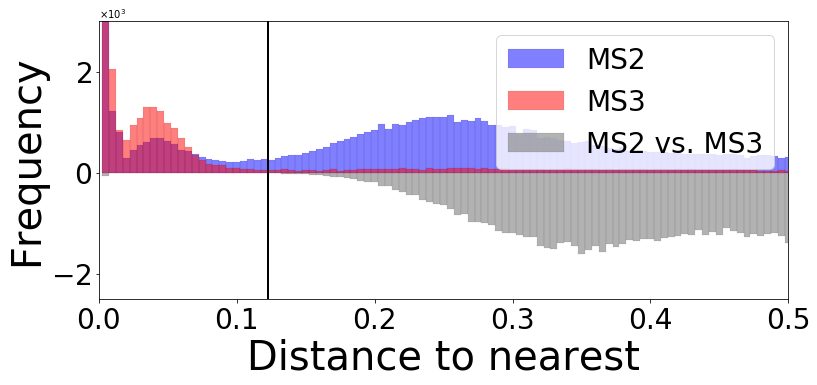

In [15]:
plt.ion()


fig, ax = plt.subplots(figsize=(12,6))


ax.bar(dist2nearesthistA[1][1:],dist2nearesthistA[0], color='b',ec='k', alpha=0.5, width=0.005,label='MS2',linewidth=0.1) 
ax.bar(dist2nearesthistA[1][1:],dist2nearesthistB[0], color='r',ec='k', alpha=0.5, width=0.005,label='MS3',linewidth=0.1)  # ,hatch='-' arguments are passed to np.histogram

ax.bar(dist2nearesthistAB[1][1:],-dist2nearesthistAB[0], color='grey',ec='k', alpha=0.6, width=0.005,label='MS2 vs. MS3',linewidth=0.1) #,hatch='/'

ax.set_xlim([0, 0.5])
ax.set_ylim([-2500,3000])
plt.ylabel('Frequency')
plt.xlabel('Distance to nearest')
#thresh_cosine=0.08
ax.vlines(x=thresh_cosine, ymin=-2500, ymax=20000, linewidth=2, color='k')
ax.ticklabel_format( axis='y', style='', scilimits=(3,2), useOffset=None, useLocale=None, useMathText=True)
ax.xaxis.label.set_fontsize(40)
ax.yaxis.label.set_fontsize(40)
ax.tick_params(labelsize=28)
plt.rcParams.update({'font.size':28})
ax.legend(fontsize=28)
plt.tight_layout()
plt.show()
fig.savefig('Figs/MS2-MS3-threshN')



In [16]:
clusters_cosine_full_A=cluster_from_matches(matches_fast[:M,:M],thresh_cosine)

In [17]:

nmi_scoreA=normalized_mutual_info_score(tableA.CLONE[0:M],clusters_cosine_full_A[:M])


In [18]:
nmi_scoreA

0.9897623205125394

In [19]:
clustersizevec_cosine,clustersizevec_table,junctionsizevec_cosine,junctionsizevec_table=compute_cluster_stats(clusters_cosine_full_A,tableA,tableA.shape[0])



/home/ofir/.local/lib/python3.5/site-packages/ipykernel_launcher.py:17: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


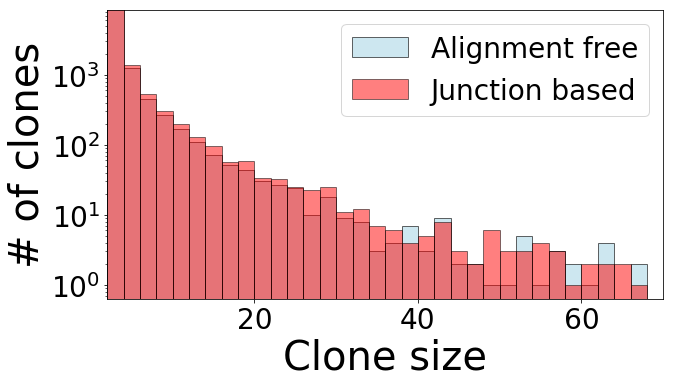

In [20]:
plt.ion()
fig, ax = plt.subplots(figsize=(10,6))


ax.hist(clustersizevec_cosine,bins=bins_clones ,color='lightblue',ec='k',width=2,alpha=0.6)# arguments are passed to np.histogram
ax.hist(clustersizevec_table,bins=bins_clones ,color='r',ec='k',width=2,alpha=0.5) #

plt.xlabel('Clone size')
plt.ylabel('# of clones')
plt.yscale('log')
legend = ['Alignment free','Junction based']
ax.xaxis.label.set_fontsize(40)
ax.yaxis.label.set_fontsize(40)
plt.legend(legend,fontsize=28)
plt.tick_params(labelsize=28)
ax.set_xlim([2, 70])
ax.set_ylim([0, 8500])
plt.tight_layout()
fig.savefig('Figs/MS2-tfidf-hamm-new')

In [21]:
clusters_cosine_full_B=cluster_from_matches(matches_fast[M:,M:],thresh_cosine)
nmi_scoreB=normalized_mutual_info_score(tableB.CLONE[:],clusters_cosine_full_B[:])

clustersizevec_cosine,clustersizevec_table,junctionsizevec_cosine,junctionsizevec_table=compute_cluster_stats(clusters_cosine_full_B,tableB,tableB.shape[0])

nmi_scoreB

0.967303087038194

/home/ofir/.local/lib/python3.5/site-packages/ipykernel_launcher.py:17: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


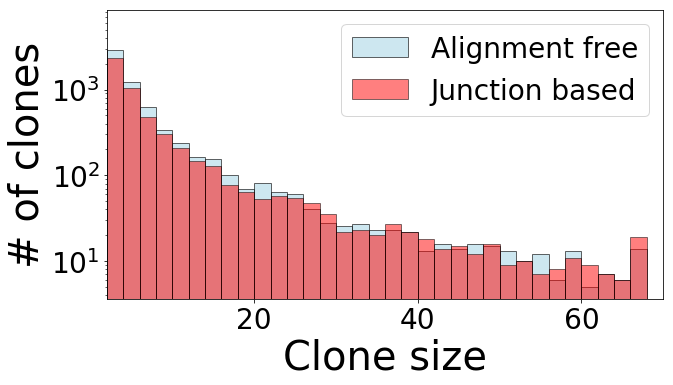

In [22]:
plt.ion()
fig, ax = plt.subplots(figsize=(10,6))

bins=np.arange(2,70,2)
ax.hist(clustersizevec_cosine,bins=bins_clones ,color='lightblue',ec='k',width=2,alpha=0.6)# arguments are passed to np.histogram
ax.hist(clustersizevec_table,bins=bins_clones ,color='r',ec='k',width=2,alpha=0.5) #

plt.xlabel('Clone size')
plt.ylabel('# of clones')
plt.yscale('log')
legend = ['Alignment free','Junction based']
ax.xaxis.label.set_fontsize(40)
ax.yaxis.label.set_fontsize(40)
plt.legend(legend,fontsize=28)
plt.tick_params(labelsize=28)
ax.set_xlim([2, 70])
ax.set_ylim([0, 8500])
plt.tight_layout()
fig.savefig('Figs/MS3-tfidf-hamm-new')

In [23]:
tableC=pd.read_csv(data_folder+'MS4_repertoir.csv')

/home/ofir/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [24]:
tableC.shape

(100000, 40)

In [25]:
df = pd.DataFrame(tableA.SEQUENCE_INPUT[:M_samples].values)
df2=pd.DataFrame(tableC.SEQUENCE_INPUT[:M_samples].values )
table_r_f=df.append(df2,ignore_index=True)
table_last=truncate_sequence_rf(table_r_f[0],W_l=150,E_l=0)
tf_idf_matrix_full = vectorizer.fit_transform(table_last.end)

matches_fast = awesome_cossim_top(tf_idf_matrix_full, tf_idf_matrix_full.transpose(), 500, 0.2)
dist2nearestcosine=compute_dist2nearest(matches_fast)
matches_fastAC = awesome_cossim_top(tf_idf_matrix_full[:M], tf_idf_matrix_full[M:].transpose(), 500, 0.2)
dist2nearestcosine_AC=compute_dist2nearest(matches_fastAC)

In [27]:
dist2nearesthistA=np.histogram(dist2nearestcosine[:M],bins=bins)
dist2nearesthistC=np.histogram(dist2nearestcosine[M:],bins=bins)
dist2nearesthistAC=np.histogram(dist2nearestcosine_AC,bins=bins)

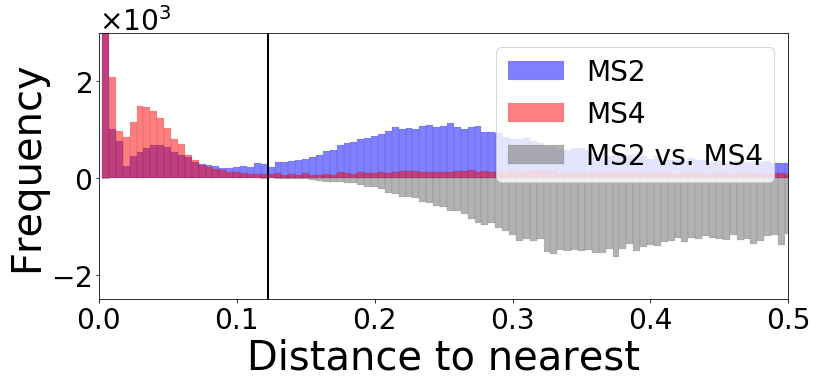

In [28]:
plt.ion()


fig, ax = plt.subplots(figsize=(12,6))


ax.bar(dist2nearesthistA[1][1:],dist2nearesthistA[0], color='b',ec='k', alpha=0.5, width=0.005,label='MS2',linewidth=0.1) 
ax.bar(dist2nearesthistA[1][1:],dist2nearesthistC[0], color='r',ec='k', alpha=0.5, width=0.005,label='MS4',linewidth=0.1)  # ,hatch='-' arguments are passed to np.histogram

ax.bar(dist2nearesthistAC[1][1:],-dist2nearesthistAC[0], color='grey',ec='k', alpha=0.6, width=0.005,label='MS2 vs. MS4',linewidth=0.1) #,hatch='/'

ax.set_xlim([0, 0.5])
ax.set_ylim([-2500,3000])
plt.ylabel('Frequency')
plt.xlabel('Distance to nearest')
#thresh_cosine=0.08
ax.vlines(x=thresh_cosine, ymin=-2500, ymax=20000, linewidth=2, color='k')
ax.ticklabel_format( axis='y', style='', scilimits=(3,2), useOffset=None, useLocale=None, useMathText=True)
ax.xaxis.label.set_fontsize(40)
ax.yaxis.label.set_fontsize(40)
ax.tick_params(labelsize=28)
plt.rcParams.update({'font.size':28})
ax.legend(fontsize=28)
plt.tight_layout()
plt.show()
fig.savefig('Figs/MS2-MS4-threshN')



In [30]:
clusters_cosine_full_C=cluster_from_matches(matches_fast[M:,M:],thresh_cosine)
nmi_scoreC=normalized_mutual_info_score(tableC.CLONE[:],clusters_cosine_full_C[:])

clustersizevec_cosine,clustersizevec_table,junctionsizevec_cosine,junctionsizevec_table=compute_cluster_stats(clusters_cosine_full_C,tableC,tableC.shape[0])

nmi_scoreC

0.9576473207820281

/home/ofir/.local/lib/python3.5/site-packages/ipykernel_launcher.py:17: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


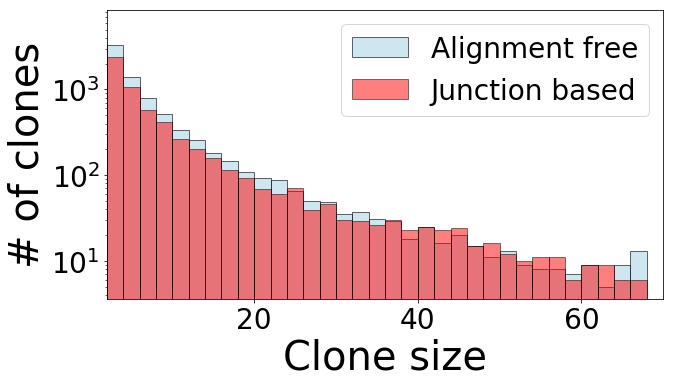

In [31]:
plt.ion()
fig, ax = plt.subplots(figsize=(10,6))


ax.hist(clustersizevec_cosine,bins=bins_clones ,color='lightblue',ec='k',width=2,alpha=0.6)# arguments are passed to np.histogram
ax.hist(clustersizevec_table,bins=bins_clones ,color='r',ec='k',width=2,alpha=0.5) #

plt.xlabel('Clone size')
plt.ylabel('# of clones')
plt.yscale('log')
legend = ['Alignment free','Junction based']
ax.xaxis.label.set_fontsize(40)
ax.yaxis.label.set_fontsize(40)
plt.legend(legend,fontsize=28)
plt.tick_params(labelsize=28)
ax.set_xlim([2, 70])
ax.set_ylim([0, 8500])
plt.tight_layout()
fig.savefig('Figs/MS4-tfidf-hamm-new')

In [32]:
tableD=pd.read_csv(data_folder+'MS5_repertoir.csv')

/home/ofir/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [33]:
df = pd.DataFrame(tableA.SEQUENCE_INPUT[:M_samples].values)
df2=pd.DataFrame(tableD.SEQUENCE_INPUT[:M_samples].values )
table_r_f=df.append(df2,ignore_index=True)
table_last=truncate_sequence_rf(table_r_f[0],W_l=150,E_l=0)
tf_idf_matrix_full = vectorizer.fit_transform(table_last.end)

matches_fast = awesome_cossim_top(tf_idf_matrix_full, tf_idf_matrix_full.transpose(), 500, 0.2)
dist2nearestcosine=compute_dist2nearest(matches_fast)
matches_fastAD = awesome_cossim_top(tf_idf_matrix_full[:M], tf_idf_matrix_full[M:].transpose(), 500, 0.2)
dist2nearestcosine_AD=compute_dist2nearest(matches_fastAD)


In [44]:
dist2nearesthistD=np.histogram(dist2nearestcosine[M:],bins=bins)
dist2nearesthistAD=np.histogram(dist2nearestcosine_AD,bins=bins)

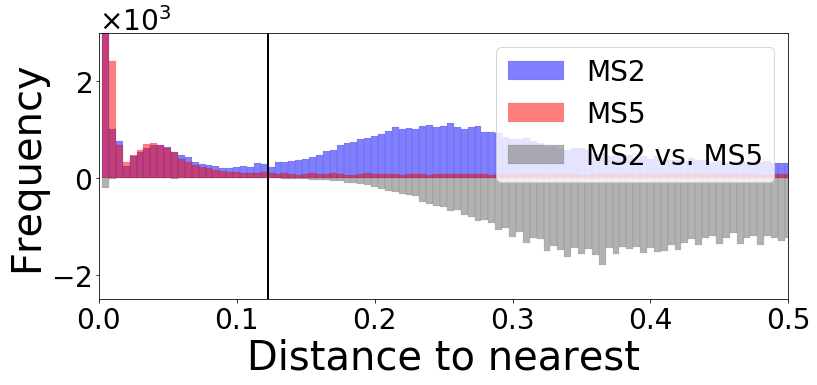

In [46]:
plt.ion()


fig, ax = plt.subplots(figsize=(12,6))


ax.bar(dist2nearesthistA[1][1:],dist2nearesthistA[0], color='b',ec='k', alpha=0.5, width=0.005,label='MS2',linewidth=0.1) 
ax.bar(dist2nearesthistD[1][1:],dist2nearesthistD[0], color='r',ec='k', alpha=0.5, width=0.005,label='MS5',linewidth=0.1)  # ,hatch='-' arguments are passed to np.histogram

ax.bar(dist2nearesthistAD[1][1:],-dist2nearesthistAD[0], color='grey',ec='k', alpha=0.6, width=0.005,label='MS2 vs. MS5',linewidth=0.1) #,hatch='/'

ax.set_xlim([0, 0.5])
ax.set_ylim([-2500,3000])
plt.ylabel('Frequency')
plt.xlabel('Distance to nearest')
#thresh_cosine=0.08
ax.vlines(x=thresh_cosine, ymin=-2500, ymax=20000, linewidth=2, color='k')
ax.ticklabel_format( axis='y', style='', scilimits=(3,2), useOffset=None, useLocale=None, useMathText=True)
ax.xaxis.label.set_fontsize(40)
ax.yaxis.label.set_fontsize(40)
ax.tick_params(labelsize=28)
plt.rcParams.update({'font.size':28})
ax.legend(fontsize=28)
plt.tight_layout()
plt.show()
fig.savefig('Figs/MS2-MS5-threshN')


In [35]:
clusters_cosine_full_D=cluster_from_matches(matches_fast[M:,M:],thresh_cosine)
nmi_scoreD=normalized_mutual_info_score(tableD.CLONE[:],clusters_cosine_full_D[:])

clustersizevec_cosine,clustersizevec_table,junctionsizevec_cosine,junctionsizevec_table=compute_cluster_stats(clusters_cosine_full_D,tableD,tableD.shape[0])

nmi_scoreD

0.921733486302194

/home/ofir/.local/lib/python3.5/site-packages/ipykernel_launcher.py:17: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


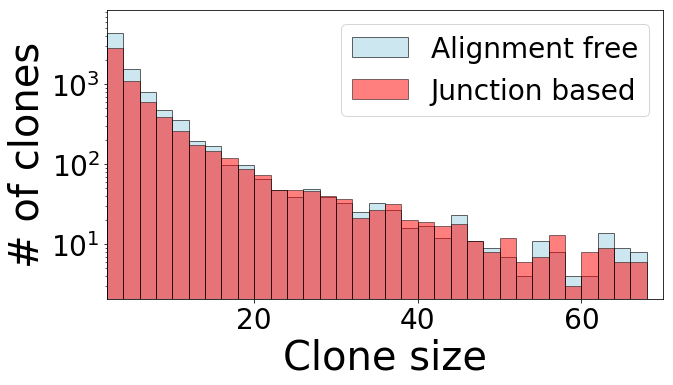

In [47]:
plt.ion()
fig, ax = plt.subplots(figsize=(10,6))

bins_clones=np.arange(2,70,2)
ax.hist(clustersizevec_cosine,bins=bins_clones ,color='lightblue',ec='k',width=2,alpha=0.6)# arguments are passed to np.histogram
ax.hist(clustersizevec_table,bins=bins_clones ,color='r',ec='k',width=2,alpha=0.5) #

plt.xlabel('Clone size')
plt.ylabel('# of clones')
plt.yscale('log')
legend = ['Alignment free','Junction based']
ax.xaxis.label.set_fontsize(40)
ax.yaxis.label.set_fontsize(40)
plt.legend(legend,fontsize=28)
plt.tick_params(labelsize=28)
ax.set_xlim([2, 70])
ax.set_ylim([0, 8500])
plt.tight_layout()
fig.savefig('Figs/MS5-tfidf-hamm-new')

In [51]:
df = pd.DataFrame(tableB.SEQUENCE_INPUT[:M_samples].values)
df2=pd.DataFrame(tableC.SEQUENCE_INPUT[:M_samples].values )
table_r_f=df.append(df2,ignore_index=True)
table_last=truncate_sequence_rf(table_r_f[0],W_l=150,E_l=0)
tf_idf_matrix_full = vectorizer.fit_transform(table_last.end)

matches_fast = awesome_cossim_top(tf_idf_matrix_full, tf_idf_matrix_full.transpose(), 500, 0.2)
dist2nearestcosine=compute_dist2nearest(matches_fast)
matches_fastBC = awesome_cossim_top(tf_idf_matrix_full[:M], tf_idf_matrix_full[M:].transpose(), 500, 0.2)
dist2nearestcosine_BC=compute_dist2nearest(matches_fastBC)
dist2nearesthistB=np.histogram(dist2nearestcosine[:M],bins=bins)
dist2nearesthistC=np.histogram(dist2nearestcosine[M:],bins=bins)
dist2nearesthistBC=np.histogram(dist2nearestcosine_BC,bins=bins)

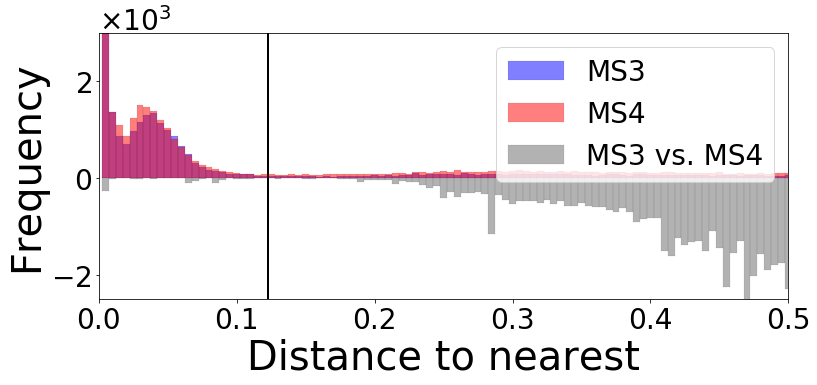

In [52]:
plt.ion()


fig, ax = plt.subplots(figsize=(12,6))


ax.bar(dist2nearesthistB[1][1:],dist2nearesthistB[0], color='b',ec='k', alpha=0.5, width=0.005,label='MS3',linewidth=0.1) 
ax.bar(dist2nearesthistC[1][1:],dist2nearesthistC[0], color='r',ec='k', alpha=0.5, width=0.005,label='MS4',linewidth=0.1)  # ,hatch='-' arguments are passed to np.histogram

ax.bar(dist2nearesthistBC[1][1:],-dist2nearesthistBC[0], color='grey',ec='k', alpha=0.6, width=0.005,label='MS3 vs. MS4',linewidth=0.1) #,hatch='/'

ax.set_xlim([0, 0.5])
ax.set_ylim([-2500,3000])
plt.ylabel('Frequency')
plt.xlabel('Distance to nearest')
#thresh_cosine=0.08
ax.vlines(x=thresh_cosine, ymin=-2500, ymax=20000, linewidth=2, color='k')
ax.ticklabel_format( axis='y', style='', scilimits=(3,2), useOffset=None, useLocale=None, useMathText=True)
ax.xaxis.label.set_fontsize(40)
ax.yaxis.label.set_fontsize(40)
ax.tick_params(labelsize=28)
plt.rcParams.update({'font.size':28})
ax.legend(fontsize=28)
plt.tight_layout()
plt.show()
fig.savefig('Figs/MS3-MS4-threshN')

In [53]:
df = pd.DataFrame(tableB.SEQUENCE_INPUT[:M_samples].values)
df2=pd.DataFrame(tableD.SEQUENCE_INPUT[:M_samples].values )
table_r_f=df.append(df2,ignore_index=True)
table_last=truncate_sequence_rf(table_r_f[0],W_l=150,E_l=0)
tf_idf_matrix_full = vectorizer.fit_transform(table_last.end)

matches_fast = awesome_cossim_top(tf_idf_matrix_full, tf_idf_matrix_full.transpose(), 500, 0.2)
dist2nearestcosine=compute_dist2nearest(matches_fast)
matches_fastBD = awesome_cossim_top(tf_idf_matrix_full[:M], tf_idf_matrix_full[M:].transpose(), 500, 0.2)
dist2nearestcosine_BD=compute_dist2nearest(matches_fastBD)
dist2nearesthistB=np.histogram(dist2nearestcosine[:M],bins=bins)
dist2nearesthistD=np.histogram(dist2nearestcosine[M:],bins=bins)
dist2nearesthistBD=np.histogram(dist2nearestcosine_BD,bins=bins)

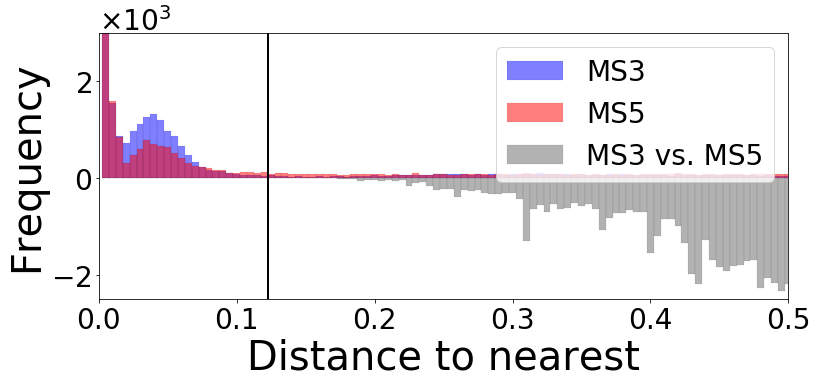

In [54]:
plt.ion()


fig, ax = plt.subplots(figsize=(12,6))


ax.bar(dist2nearesthistB[1][1:],dist2nearesthistB[0], color='b',ec='k', alpha=0.5, width=0.005,label='MS3',linewidth=0.1) 
ax.bar(dist2nearesthistD[1][1:],dist2nearesthistD[0], color='r',ec='k', alpha=0.5, width=0.005,label='MS5',linewidth=0.1)  # ,hatch='-' arguments are passed to np.histogram

ax.bar(dist2nearesthistBD[1][1:],-dist2nearesthistBD[0], color='grey',ec='k', alpha=0.6, width=0.005,label='MS3 vs. MS5',linewidth=0.1) #,hatch='/'

ax.set_xlim([0, 0.5])
ax.set_ylim([-2500,3000])
plt.ylabel('Frequency')
plt.xlabel('Distance to nearest')
#thresh_cosine=0.08
ax.vlines(x=thresh_cosine, ymin=-2500, ymax=20000, linewidth=2, color='k')
ax.ticklabel_format( axis='y', style='', scilimits=(3,2), useOffset=None, useLocale=None, useMathText=True)
ax.xaxis.label.set_fontsize(40)
ax.yaxis.label.set_fontsize(40)
ax.tick_params(labelsize=28)
plt.rcParams.update({'font.size':28})
ax.legend(fontsize=28)
plt.tight_layout()
plt.show()
fig.savefig('Figs/MS3-MS5-threshN')

In [55]:
df = pd.DataFrame(tableC.SEQUENCE_INPUT[:M_samples].values)
df2=pd.DataFrame(tableD.SEQUENCE_INPUT[:M_samples].values )
table_r_f=df.append(df2,ignore_index=True)
table_last=truncate_sequence_rf(table_r_f[0],W_l=150,E_l=0)
tf_idf_matrix_full = vectorizer.fit_transform(table_last.end)

matches_fast = awesome_cossim_top(tf_idf_matrix_full, tf_idf_matrix_full.transpose(), 500, 0.2)
dist2nearestcosine=compute_dist2nearest(matches_fast)
matches_fastCD = awesome_cossim_top(tf_idf_matrix_full[:M], tf_idf_matrix_full[M:].transpose(), 500, 0.2)
dist2nearestcosine_CD=compute_dist2nearest(matches_fastCD)
dist2nearesthistC=np.histogram(dist2nearestcosine[:M],bins=bins)
dist2nearesthistD=np.histogram(dist2nearestcosine[M:],bins=bins)
dist2nearesthistCD=np.histogram(dist2nearestcosine_CD,bins=bins)

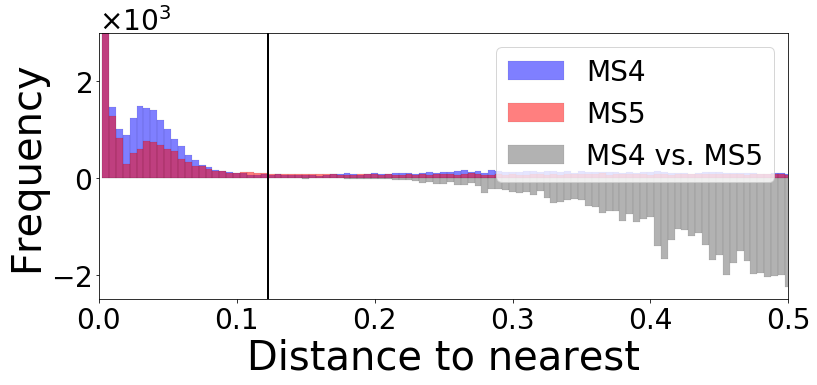

In [56]:
plt.ion()


fig, ax = plt.subplots(figsize=(12,6))


ax.bar(dist2nearesthistC[1][1:],dist2nearesthistC[0], color='b',ec='k', alpha=0.5, width=0.005,label='MS4',linewidth=0.1) 
ax.bar(dist2nearesthistD[1][1:],dist2nearesthistD[0], color='r',ec='k', alpha=0.5, width=0.005,label='MS5',linewidth=0.1)  # ,hatch='-' arguments are passed to np.histogram

ax.bar(dist2nearesthistCD[1][1:],-dist2nearesthistCD[0], color='grey',ec='k', alpha=0.6, width=0.005,label='MS4 vs. MS5',linewidth=0.1) #,hatch='/'

ax.set_xlim([0, 0.5])
ax.set_ylim([-2500,3000])
plt.ylabel('Frequency')
plt.xlabel('Distance to nearest')
#thresh_cosine=0.08
ax.vlines(x=thresh_cosine, ymin=-2500, ymax=20000, linewidth=2, color='k')
ax.ticklabel_format( axis='y', style='', scilimits=(3,2), useOffset=None, useLocale=None, useMathText=True)
ax.xaxis.label.set_fontsize(40)
ax.yaxis.label.set_fontsize(40)
ax.tick_params(labelsize=28)
plt.rcParams.update({'font.size':28})
ax.legend(fontsize=28)
plt.tight_layout()
plt.show()
fig.savefig('Figs/MS4-MS5-threshN')